In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm
import config
import process_data

In [2]:
# define ivim function
def ivim(b, Dp, Dt, Fp):
    return Fp*np.exp(-b*Dp) + (1-Fp)*np.exp(-b*Dt)

# apply mask: only keep vox with mask = 1

**Single subject Data 100206**

In [3]:
scan = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')

In [7]:
mask = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [8]:
scan_dimension = scan.shape
x = scan_dimension[0]
y = scan_dimension[1]
z = scan_dimension[2]
b = scan_dimension[3]

In [9]:
print(x, y, z, b)

print('The shape of scan: ')
print(scan.shape)
print('The shape of mask: ')
print(mask.shape)

print(type(scan), type(mask))

145 174 145 288
The shape of scan: 
(145, 174, 145, 288)
The shape of mask: 
(145, 174, 145)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [10]:
scan_long = np.reshape(scan, (x*y*z, b))

In [11]:
mask_long = np.reshape(mask, (x*y*z, 1))

In [12]:
scan_long_no_background = process_data.trim_background(scan_long, mask_long)

In [13]:
scan_long_no_background.shape

(936256, 288)

In [14]:
scan_long_no_bg_cp = scan_long_no_background

In [15]:
def find_rows_beginning_with_zero(scan_long_no_bg):
    return np.where(scan_long_no_bg[:, 0] == 0)[0]

In [16]:
# Get strange data

Sb_beginning_0 = find_rows_beginning_with_zero(scan_long_no_background)

[ 46080  52289  58710  61649  65169  75865  77984  82681  88184  96165
  96248  98616 104386 104471 105834 106935 112589 112845 112930 115186
 115316 121280 121706 124612 127409 130165 130591 132693 133084 133597
 137541 139400 139753 141694 141918 142846 148444 148806 149505 149838
 151134 151227 151272 152002 152206 152349 152407 154601 156409 158104
 158288 158471 159177 159511 160888 160932 161452 161721 161983 161984
 162113 162132 162210 167928 168205 168297 169004 169341 171395 171798
 171931 171948 172006 172027 172164 172422 172512 172608 172704 178028
 178213 179261 181980 182142 182491 182588 182685 188111 188564 189253
 189586 191392 191682 192585 192681 192778 198338 199046 199391 199725
 201834 202277 202792 205301 208912 209605 209942 211902 211903 211904
 212326 212401 212557 212638 212724 220226 222749 222985 223070 223332
 223424 223517 229542 231390 232879 232945 233016 233752 239966 240315
 242898 242904 242905 242929 243527 243586 243987 244080 244174 246697
 25350

In [36]:
print(type(Sb_beginning_0))

<class 'numpy.ndarray'>


In [17]:
scan_long_no_bg = np.delete(scan_long_no_background, Sb_beginning_0, 0)

In [18]:
print(scan_long_no_bg.shape)
print(scan_long_no_background.shape)
print(814+935442)

(935442, 288)
(936256, 288)
936256


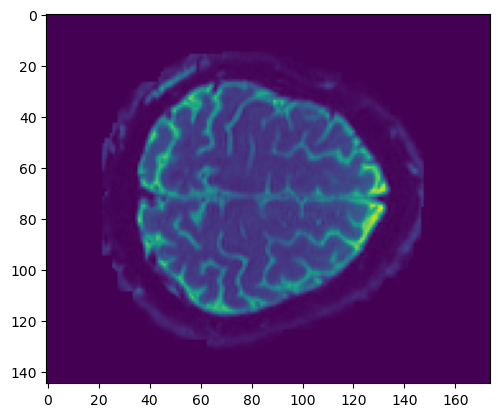

In [17]:
plt.imshow(scan[:,:,100, 0])

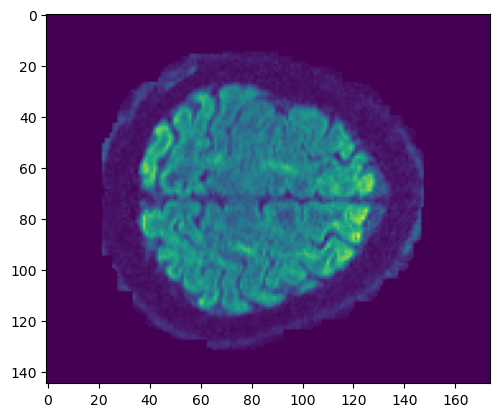

In [16]:
plt.imshow(scan[:,:,100, 1])

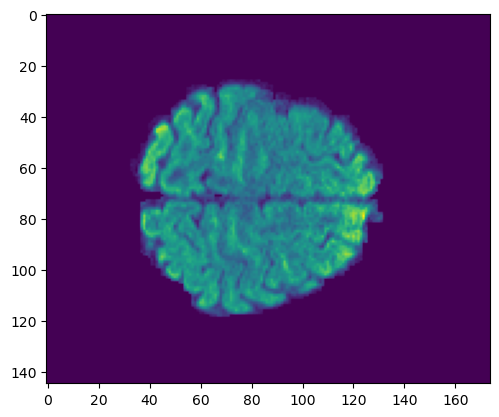

In [42]:
plt.imshow(scan[:,:,100, 10]*mask[:,:,100])

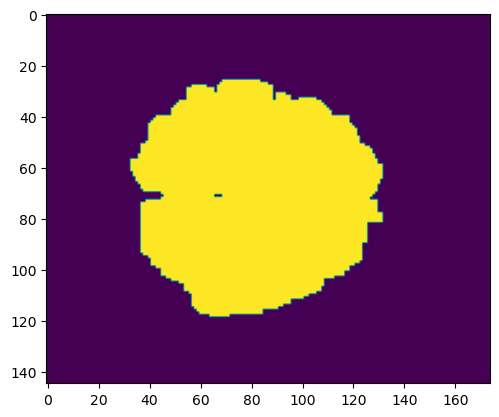

In [43]:
plt.imshow(mask[:,:,100])

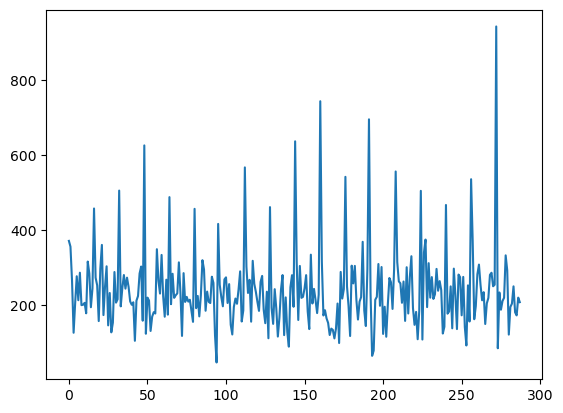

In [15]:
plt.plot(scan_long_no_background[100,:])
# plt.plot(scan_long_no_bg[96165,:])

In [19]:
bval_list = np.loadtxt(config.data_folder2 + '/100206/bvals')

In [ ]:
plt.plot(bval_list, scan_long_no_background[0,:])

In [20]:
print(np.where(bval_list == 5))

(array([  0,  16,  32,  48,  64,  80,  95, 112, 128, 144, 160, 176, 191,
       208, 224, 240, 256, 272]),)


In [21]:
print(type(bval_list))
print(bval_list)

<class 'numpy.ndarray'>
[   5. 1000. 1995. 3005.  995. 2995. 2005.  990. 1990. 3000. 1000. 1985.
 2995. 1005. 1995. 2995.    5.  995. 2000. 3010. 3005.  995. 2005.  995.
 1990. 2985. 1005. 2000. 3005.  995. 1995. 2990.    5. 3005.  995. 2000.
  990. 1990. 2990.  995. 2985. 1995. 3005.  995. 2005. 1000. 1990. 2995.
    5. 1005. 2005. 2995. 3000. 1005. 1985. 1005. 2985. 2005.  995. 1990.
 3005. 1000. 2990. 2000.    5.  990. 2005. 2995. 1000. 2005. 3000.  995.
 2005. 3005. 1005. 2000. 3010.  990. 2005. 1995.    5. 1000. 3010. 2985.
 1005. 1995. 3000. 1000. 2005. 3000.  990. 2005. 2990. 3000. 1000.    5.
 2990.  995. 1995. 1995. 1005. 2000. 2995. 1005. 2010. 2995. 1005. 2000.
 3010. 1000. 2005. 2990.    5.  990. 2985. 2005. 1000. 2005. 2985.  995.
 2005. 2990.  995. 2005. 2990. 1005. 2000. 3005.    5.  995. 2995. 1990.
 1005.  995. 2005. 2990. 2000. 3000. 1000. 2005. 2985.  990. 1995. 2985.
    5.  990. 2000. 3010.  995. 1990. 2995. 1005. 2000. 3005. 1000. 1990.
 2995. 2000.  995. 2990.   

In [22]:
S0 = process_data.get_S0(scan_long_no_bg, bval_list)

In [23]:
print(S0.shape)

(935442, 1)


In [43]:
error_voxels = np.argwhere(np.logical_and(S0 >= 0, S0 < 1))[:,0]

In [44]:
error_voxels

array([], dtype=int64)

In [47]:
np.save('S0_1.npy',S0)
# S0 = np.load('S0_1.npy')

In [40]:
scan_long_no_bg = np.delete(scan_long_no_bg, error_voxels, 0)
S0 = np.delete(S0, error_voxels, 0)

In [50]:
normalized_scan_long_no_background = process_data.normalize_scan(scan_long_no_bg, S0)

In [118]:
# np.save('normalized_scan_long_1.npy', normalized_scan_long_no_background)
normalized_scan_long_no_background = np.load('normalized_scan_long5.npy')

In [57]:
np.argwhere(normalized_scan_long_no_background > 10)

array([[117489,      4],
       [117489,     20],
       [117489,     60],
       ...,
       [784703,    214],
       [784703,    231],
       [838711,     90]])

## Neural Network Training

Let's create the neural network class and instantiate it.

In [119]:
class Net(nn.Module):
    def __init__(self, b_values_no0):
        super(Net, self).__init__()

        self.b_values_no0 = b_values_no0
        self.fc_layers = nn.ModuleList()
        for i in range(3): # 3 fully connected hidden layers
            self.fc_layers.extend([nn.Linear(len(b_values_no0), len(b_values_no0)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values_no0), 3))

    def forward(self, X):
        # print('x')
        # print(X.shape)
        params = torch.abs(self.encoder(X)) # Dp, Dt, Fp
        # print(params.shape)
        # print(params)
        Dp = params[:, 0].unsqueeze(1)
        Dt = params[:, 1].unsqueeze(1)
        Fp = params[:, 2].unsqueeze(1)

        X = Fp*torch.exp(-self.b_values_no0*Dp) + (1-Fp)*torch.exp(-self.b_values_no0*Dt)

        return X, Dp, Dt, Fp

In [120]:
net = Net(bval_list)
print(net)

Net(
  (fc_layers): ModuleList(
    (0): Linear(in_features=288, out_features=288, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=288, out_features=288, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=288, out_features=288, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=288, out_features=288, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=288, out_features=288, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=288, out_features=288, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=288, out_features=3, bias=True)
  )
)


In [121]:
# Network
b_values = torch.FloatTensor(bval_list)
net = Net(b_values)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)  

In [122]:
print(b_values.shape)
print(b_values.type)

torch.Size([288])
<built-in method type of Tensor object at 0x195aa0950>


Create batch queues.

In [123]:
batch_size = 128
num_batches = len(normalized_scan_long_no_background) // batch_size
# X_train = X_train[:,1:] # exlude the b=0 value as signals are normalized
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_long_no_background.astype(np.float32)),
                                batch_size = batch_size, 
                                shuffle = True,
                                num_workers = 2,
                                drop_last = True)

Train, this might take a few minutes.

In [65]:
# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

# Train
counter = 0
for epoch in range(1000): 
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        # print('Running_loss: ', running_loss)
        # print('X_batch: ')
        # print(X_batch.shape)
        # print(X_batch)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        X_pred, Dp_pred, Dt_pred, Fp_pred = net(X_batch)
        # print('X_pred: ')
        # print(X_pred.shape)
        # print(X_pred)
        if i == 8 and counter == 10:
            print(X_pred)
        loss = criterion(X_pred, X_batch)
        loss.backward()
        optimizer.step()
        # print('loss: ', loss.item())
        running_loss += loss.item()

    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/len(trainloader)))
    # early stopping
    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1
print("Done")
# Restore best model
net.load_state_dict(final_model)
#        DP            Dt           Fp

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|██████████████████████████████████████| 7308/7308 [00:31<00:00, 230.80it/s]


Loss: 1223.9601939618587
Average Loss: 0.1674822378163463
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|██████████████████████████████████████| 7308/7308 [00:32<00:00, 222.42it/s]


Loss: 1212.7655461803079
Average Loss: 0.16595040314454132
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|██████████████████████████████████████| 7308/7308 [00:31<00:00, 230.56it/s]


Loss: 1149.2508404813707
Average Loss: 0.15725928304342784
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|██████████████████████████████████████| 7308/7308 [00:31<00:00, 230.66it/s]


Loss: 950.4982717186213
Average Loss: 0.13006270822641233
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|██████████████████████████████████████| 7308/7308 [00:34<00:00, 213.87it/s]


Loss: 745.3897270783782
Average Loss: 0.1019964049094661
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|██████████████████████████████████████| 7308/7308 [00:32<00:00, 226.56it/s]


Loss: 635.3921753549948
Average Loss: 0.08694474211206826
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|██████████████████████████████████████| 7308/7308 [00:35<00:00, 205.75it/s]


Loss: 694.4642104385421
Average Loss: 0.09502794340976219
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 1


100%|██████████████████████████████████████| 7308/7308 [00:39<00:00, 185.84it/s]


Loss: 626.3098311256617
Average Loss: 0.08570194733520275
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|██████████████████████████████████████| 7308/7308 [00:31<00:00, 228.41it/s]


Loss: 640.3578482391313
Average Loss: 0.08762422663370707
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 1


100%|██████████████████████████████████████| 7308/7308 [00:32<00:00, 222.93it/s]


Loss: 602.9134212648496
Average Loss: 0.08250046815337296
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


  1%|▎                                        | 50/7308 [00:01<02:39, 45.63it/s]

tensor([[0.9208, 0.0298, 0.0099,  ..., 0.0296, 0.0099, 0.0033],
        [0.9575, 0.3898, 0.2343,  ..., 0.3888, 0.2343, 0.1401],
        [0.9455, 0.4432, 0.3877,  ..., 0.4429, 0.3877, 0.3386],
        ...,
        [0.9356, 0.2793, 0.1310,  ..., 0.2782, 0.1310, 0.0610],
        [0.9570, 0.3331, 0.2139,  ..., 0.3324, 0.2139, 0.1368],
        [0.9430, 0.2406, 0.1093,  ..., 0.2397, 0.1093, 0.0493]],
       grad_fn=<AddBackward0>)


100%|██████████████████████████████████████| 7308/7308 [00:32<00:00, 225.06it/s]


Loss: 651.8211833536625
Average Loss: 0.08919282749776443
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 1


100%|██████████████████████████████████████| 7308/7308 [00:31<00:00, 228.39it/s]


Loss: 742.4850358068943
Average Loss: 0.10159893757620338
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 2


100%|██████████████████████████████████████| 7308/7308 [00:33<00:00, 220.39it/s]


Loss: 682.5828134678304
Average Loss: 0.0934021364898509
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 3


100%|██████████████████████████████████████| 7308/7308 [00:32<00:00, 223.66it/s]


Loss: 655.0774002065882
Average Loss: 0.08963839630632023
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 4


100%|██████████████████████████████████████| 7308/7308 [00:32<00:00, 225.39it/s]


Loss: 606.1077348235995
Average Loss: 0.0829375663414887
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 5


100%|██████████████████████████████████████| 7308/7308 [00:32<00:00, 223.67it/s]


Loss: 638.0891695488244
Average Loss: 0.08731378893662074
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 6


100%|██████████████████████████████████████| 7308/7308 [00:33<00:00, 216.70it/s]


Loss: 648.134201258421
Average Loss: 0.08868831434844293
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 7


100%|██████████████████████████████████████| 7308/7308 [00:34<00:00, 211.36it/s]


Loss: 678.0769911017269
Average Loss: 0.0927855762317634
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 8


100%|██████████████████████████████████████| 7308/7308 [00:32<00:00, 223.22it/s]


Loss: 627.1710513746366
Average Loss: 0.08581979356522121
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 9


100%|██████████████████████████████████████| 7308/7308 [00:33<00:00, 217.52it/s]

Loss: 653.4666066551581
Average Loss: 0.08941798120623401
Done, best loss: 602.9134212648496
Done


<All keys matched successfully>

In [113]:
torch.save(final_model, 'model_no_ab_data.pt')

In [114]:
net.load_state_dict(torch.load('model_no_ab_data.pt'))

<All keys matched successfully>

In [115]:
X, Dp, Dt, Fp = net(torch.from_numpy(normalized_scan_long_no_background.astype(np.float32)))

In [117]:
X[1]

tensor([0.9459, 0.2661, 0.1107, 0.0455, 0.2672, 0.0459, 0.1098, 0.2684, 0.1112,
        0.0457, 0.2661, 0.1117, 0.0459, 0.2649, 0.1107, 0.0459, 0.9459, 0.2672,
        0.1102, 0.0453, 0.0455, 0.2672, 0.1098, 0.2672, 0.1112, 0.0463, 0.2649,
        0.1102, 0.0455, 0.2672, 0.1107, 0.0461, 0.9459, 0.0455, 0.2672, 0.1102,
        0.2684, 0.1112, 0.0461, 0.2672, 0.0463, 0.1107, 0.0455, 0.2672, 0.1098,
        0.2661, 0.1112, 0.0459, 0.9459, 0.2649, 0.1098, 0.0459, 0.0457, 0.2649,
        0.1117, 0.2649, 0.0463, 0.1098, 0.2672, 0.1112, 0.0455, 0.2661, 0.0461,
        0.1102, 0.9459, 0.2684, 0.1098, 0.0459, 0.2661, 0.1098, 0.0457, 0.2672,
        0.1098, 0.0455, 0.2649, 0.1102, 0.0453, 0.2684, 0.1098, 0.1107, 0.9459,
        0.2661, 0.0453, 0.0463, 0.2649, 0.1107, 0.0457, 0.2661, 0.1098, 0.0457,
        0.2684, 0.1098, 0.0461, 0.0457, 0.2661, 0.9459, 0.0461, 0.2672, 0.1107,
        0.1107, 0.2649, 0.1102, 0.0459, 0.2649, 0.1093, 0.0459, 0.2649, 0.1102,
        0.0453, 0.2661, 0.1098, 0.0461, 

In [112]:
normalized_scan_long_no_background[0]

array([1.30231222, 0.79474696, 0.5139521 , 0.43208811, 0.76424263,
       0.67185225, 0.62095224, 0.89252192, 0.50431463, 0.26155427,
       0.38166048, 0.655396  , 0.50740975, 0.36179775, 0.41590528,
       0.57002732, 0.90807904, 0.78176067, 0.50532199, 0.54320682,
       0.60095894, 0.57121344, 0.34920728, 0.6822784 , 0.56516249,
       0.52304688, 0.75032289, 0.5815895 , 0.58644621, 0.60180785,
       0.45803777, 0.61936955, 1.04339046, 0.64839691, 0.39603862,
       0.18933549, 0.35371684, 0.56276892, 0.34228518, 0.51946218,
       0.31336673, 0.30355206, 0.52984674, 0.43238887, 0.44295371,
       0.47000164, 0.60064617, 0.64380376, 0.85126785, 0.67112883,
       0.53182613, 0.44692895, 0.37113365, 0.61863096, 0.66124599,
       0.29644392, 0.42934769, 0.63595413, 0.60450377, 0.51659329,
       0.59525075, 0.65555411, 0.44123023, 0.33400325, 1.40246789,
       0.30419233, 0.48434566, 0.7158809 , 0.51087295, 0.42206365,
       0.36245095, 0.48321149, 0.36169222, 0.43522382, 0.74840

In [74]:
print(np.unique(bval_list))

[   5.  990.  995. 1000. 1005. 1985. 1990. 1995. 2000. 2005. 2010. 2980.
 2985. 2990. 2995. 3000. 3005. 3010.]


## Simulated Diffusion-Weighted MR Image

Create a simulated diffusion-weighted image. The image contains three regions with different Dp, Dt, and Fp values. 

In [99]:
b_arr1 = np.arange(281)
b_values_simulation = np.append(np.array([5,990,995,1000,5,990,995,1000]), b_arr1)

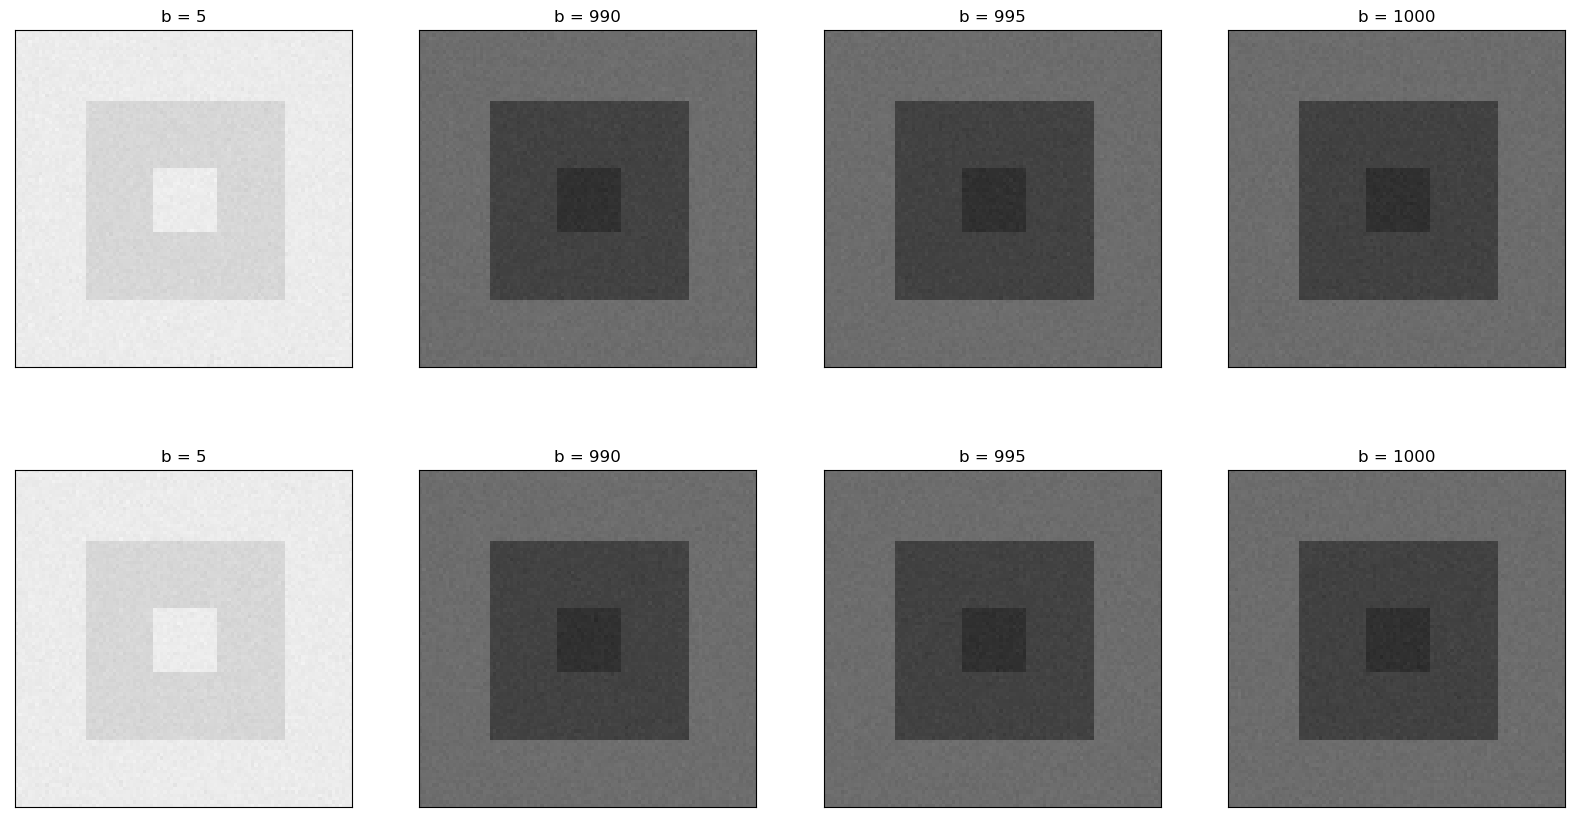

In [109]:
# define parameter values in the three regions
S0_region0, S0_region1, S0_region2 = 1500, 1400, 1600
Dp_region0, Dp_region1, Dp_region2 = 0.02, 0.04, 0.06
Dt_region0, Dt_region1, Dt_region2 = 0.0015, 0.0010, 0.0005
Fp_region0, Fp_region1, Fp_region2 = 0.1, 0.2, 0.3
# image size
sx, sy, sb = 100, 100, len(b_values_simulation)
# create image
dwi_image = np.zeros((sx, sy, sb))
Dp_truth = np.zeros((sx, sy))
Dt_truth = np.zeros((sx, sy))
Fp_truth = np.zeros((sx, sy))
# fill image with simulated values
for i in range(sx):
    for j in range(sy):
        if (40 < i < 60) and (40 < j < 60):
            # region 0
            dwi_image[i, j, :] = S0_region0*ivim(b_values_simulation, Dp_region0, Dt_region0, Fp_region0)
            Dp_truth[i, j], Dt_truth[i, j], Fp_truth[i, j] = Dp_region0, Dt_region0, Fp_region0
        elif (20 < i < 80) and (20 < j < 80):
            # region 1
            dwi_image[i, j, :] = S0_region1*ivim(b_values_simulation, Dp_region1, Dt_region1, Fp_region1)
            Dp_truth[i, j], Dt_truth[i, j], Fp_truth[i, j] = Dp_region1, Dt_region1, Fp_region1
        else:
            # region 2
            dwi_image[i, j, :] = S0_region2*ivim(b_values_simulation, Dp_region2, Dt_region2, Fp_region2)
            Dp_truth[i, j], Dt_truth[i, j], Fp_truth[i, j] = Dp_region2, Dt_region2, Fp_region2
# add some noise
dwi_image_real = dwi_image + np.random.normal(scale=15, size=(sx, sy, sb))
dwi_image_imag = np.random.normal(scale=15, size=(sx, sy, sb))
dwi_image = np.sqrt(dwi_image_real**2 + dwi_image_imag**2)
# plot simulated diffusion weighted image
fig, ax = plt.subplots(2, 4, figsize=(20,20))
b_id = 0
for i in range(2):
    for j in range(4):
        ax[i, j].imshow(dwi_image[:, :, b_id], cmap='gray', clim=(0, 1600))
        ax[i, j].set_title('b = ' + str(b_values_simulation[b_id]))
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        b_id += 1
plt.subplots_adjust(hspace=-0.6)
plt.show()


## Inference

Estimate IVIM parameter values for the simulated image.

In [105]:
# normalize signal
dwi_image_long = np.reshape(dwi_image, (sx*sy, sb))
S0 = np.expand_dims(dwi_image_long[:,0], axis=-1)
dwi_image_long = dwi_image_long[:,1:]/S0

net.eval()
with torch.no_grad():
    _, Dp, Dt, Fp = net(torch.from_numpy(dwi_image_long.astype(np.float32)))
    
Dp = Dp.numpy()
Dt = Dt.numpy()
Fp = Fp.numpy()

# make sure Dp is the larger value between Dp and Dt
if np.mean(Dp) < np.mean(Dt):
    Dp, Dt = Dt, Dp
    Fp = 1 - Fp

Plot parameter estimates and corresponding ground truths.

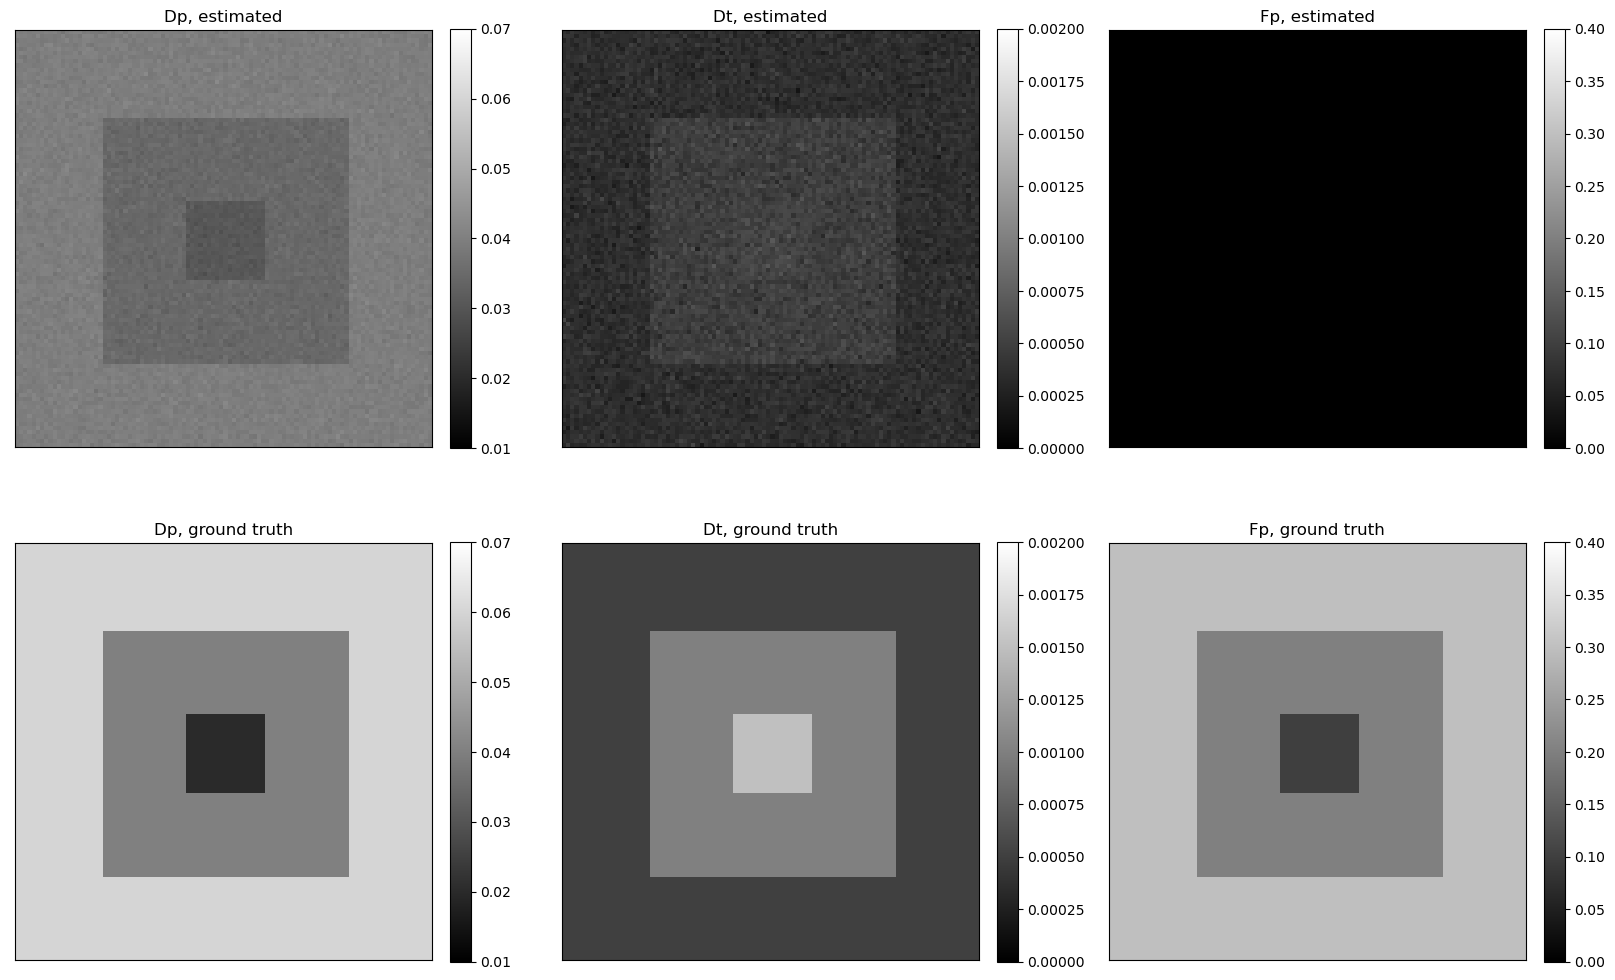

In [106]:
fig, ax = plt.subplots(2, 3, figsize=(20,20))

Dp_plot = ax[0,0].imshow(np.reshape(Dp, (sx, sy)), cmap='gray', clim=(0.01, 0.07))
ax[0,0].set_title('Dp, estimated')
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
fig.colorbar(Dp_plot, ax=ax[0,0], fraction=0.046, pad=0.04)

Dp_t_plot = ax[1,0].imshow(Dp_truth, cmap='gray', clim=(0.01, 0.07))
ax[1,0].set_title('Dp, ground truth')
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
fig.colorbar(Dp_t_plot, ax=ax[1,0], fraction=0.046, pad=0.04)

Dt_plot = ax[0,1].imshow(np.reshape(Dt, (sx, sy)), cmap='gray', clim=(0, 0.002))
ax[0,1].set_title('Dt, estimated')
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
fig.colorbar(Dt_plot, ax=ax[0,1],fraction=0.046, pad=0.04)

Dt_t_plot = ax[1,1].imshow(Dt_truth, cmap='gray', clim=(0, 0.002))
ax[1,1].set_title('Dt, ground truth')
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
fig.colorbar(Dt_t_plot, ax=ax[1,1], fraction=0.046, pad=0.04)

Fp_plot = ax[0,2].imshow(np.reshape(Fp, (sx, sy)), cmap='gray', clim=(0, 0.4))
ax[0,2].set_title('Fp, estimated')
ax[0,2].set_xticks([])
ax[0,2].set_yticks([])
fig.colorbar(Fp_plot, ax=ax[0,2],fraction=0.046, pad=0.04)

Fp_t_plot = ax[1,2].imshow(Fp_truth, cmap='gray', clim=(0, 0.4))
ax[1,2].set_title('Fp, ground truth')
ax[1,2].set_xticks([])
ax[1,2].set_yticks([])
fig.colorbar(Fp_t_plot, ax=ax[1,2], fraction=0.046, pad=0.04)

plt.subplots_adjust(hspace=-0.5)
plt.show()